In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

# import seaborn as sns
from matplotlib import pyplot as plt
import plotly.express as px
import plotly

In [11]:
dataset_indicators= pd.read_csv(r"G:\Study\USC\data incubator\dataSource\inform-covid-indicators.csv")
dataset_covid19_cases = pd.read_csv(r"G:\Study\USC\data incubator\dataSource\johns-hopkins-covid-19-daily-dashboard-cases-by-country.csv")
dataset_covid_test_performed= pd.read_csv(r"G:\Study\USC\data incubator\dataSource\total-covid-19-tests-performed-by-country.csv")

In [12]:

# just to display data f rom diff
dataset_indicators.tail(10)
dataset_covid19_cases.tail(5)
dataset_covid_test_performed.tail(5)

# Aggregating the cases by countries to get the latest confirmed cases, deaths and recovered cases
dataset_confirmed_cases_by_country = dataset_covid19_cases[['country_region', 'confirmed', 'deaths', 'recovered', 'active']]


#Grouped the confirmed cases, daeths and recovered cases by country
dataset_confirmed_cases_by_country=dataset_confirmed_cases_by_country.groupby(['country_region']).sum()
dataset_confirmed_cases_by_country.tail(10) 


#resetting the index
dataset_confirmed_cases_by_country=dataset_confirmed_cases_by_country.reset_index()
dataset_confirmed_cases_by_country.tail(10)

,country_region,confirmed,deaths,recovered,active
173,United Arab Emirates,1798,10,144,1644
174,United Kingdom,48406,4943,229,43234
175,Uruguay,400,5,93,302
176,Uzbekistan,310,2,30,278
177,Venezuela,155,7,52,96
178,Vietnam,241,0,90,151
179,West Bank and Gaza,234,1,23,210
180,Western Sahara,4,0,0,4
181,Zambia,39,1,3,35
182,Zimbabwe,9,1,0,8


In [14]:
# Plotting the confirmed cases on the world map

data = [dict(type='choropleth',
             locations = dataset_confirmed_cases_by_country['country_region'].astype(str),
             z=dataset_confirmed_cases_by_country['confirmed'].astype(int),
             locationmode='country names')]
fig = dict(data=data, 
           layout_title_text="COVID-19 Confirmed cases")


plotly.offline.plot(fig)


'temp-plot.html'

In [15]:

# Plotting the no. of test performed across different countries¶
data = [dict(type='choropleth',
             locations = dataset_covid_test_performed['entity'].astype(str),
             z=dataset_covid_test_performed['total_covid_19_tests'].astype(int),
             locationmode='country names')]

fig = dict(data=data, 
           layout_title_text="COVID-19 test performed")

plotly.offline.plot(fig)

'temp-plot.html'

In [7]:


# Matching Country Names from Covid cases and data indicator file to join the datasets

# cleaning the country names for joining
dataset_confirmed_cases_by_country.loc[dataset_confirmed_cases_by_country.country_region=='US','country_region']='United States of America'
dataset_indicators.loc[dataset_indicators.country=='Viet Nam','country']='Vietnam'
dataset_indicators.loc[dataset_indicators.country=='Russian Federation','country']='Russia'
dataset_indicators.loc[dataset_indicators.country=='Korea Republic of','country']='Korea, South'
dataset_indicators.loc[dataset_indicators.country=='Moldova Republic of','country']='Moldova'
dataset_covid_test_performed.loc[dataset_covid_test_performed.entity=='United States','entity']='United States of America'

#replace No Data with 0
dataset_indicators=dataset_indicators.replace("No data", 0)


#renaming country column name to country_region for joing the two dataframes
dataset_indicators.columns=['country_region', 'iso3', 'inform_risk',
       'inform_p2p_hazard_and_exposure_dimension', 'population_density',
       'population_living_in_urban_areas',
       'proportion_of_population_with_basic_handwashing_facilities_on_premises',
       'people_using_at_least_basic_sanitation_services',
       'inform_vulnerability', 'inform_health_conditions',
       'inform_epidemic_vulnerability', 'mortality_rate_under_5',
       'prevalence_of_undernourishment', 'inform_lack_of_coping_capacity',
       'inform_access_to_healthcare',
       'inform_epidemic_lack_of_coping_capacity', 'physicians_density',
       'current_health_expenditure_per_capita', 'maternal_mortality_ratio']

In [8]:

# outer join between cases in different countries and countries health indicators
data_tmp=pd.merge(dataset_confirmed_cases_by_country,dataset_indicators,  on='country_region', how='outer')
# Left join the resultant dataset with no. of test performd in different countries
data_tmp=pd.merge(data_tmp,dataset_covid_test_performed,  left_on='country_region', right_on='entity',how='left')
data_tmp.tail(2)
data_tmp=data_tmp.replace(np.nan, 0)
data_tmp=data_tmp.replace('x', 0)
data_tmp.tail(40)


# creating  dataset with numeric values
data_k =data_tmp[['total_covid_19_tests', 'confirmed', 'deaths', 'recovered', 'active',
                  'inform_risk', 'inform_p2p_hazard_and_exposure_dimension',
       'population_density', 'population_living_in_urban_areas',
       'proportion_of_population_with_basic_handwashing_facilities_on_premises',
       'people_using_at_least_basic_sanitation_services',
       'inform_vulnerability', 'inform_health_conditions',
       'inform_epidemic_vulnerability', 'mortality_rate_under_5',
       'prevalence_of_undernourishment', 'inform_lack_of_coping_capacity',
       'inform_access_to_healthcare',                
       'current_health_expenditure_per_capita', 'maternal_mortality_ratio']]

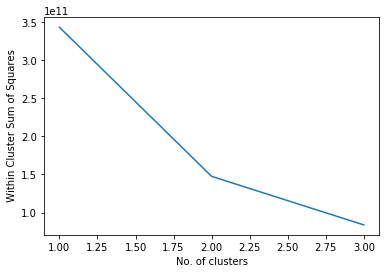

In [9]:


# KMeans clustering to identify countries with similar risk level for Covid-19

from sklearn.cluster import KMeans
#calculating WCSS which is the sum of squares of the distances of each data point represeting a country
#in all clusters to their respective centroids
wcss=[]
for i in range(1,4):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10)
    y_means = kmeans.fit(data_k)
    wcss.append(y_means.inertia_)
#Plotting WCSS to find the number of clusters
plt.plot(range(1,4), wcss)
plt.xlabel("No. of clusters")
plt.ylabel(" Within Cluster Sum of Squares")
plt.show()


C:\Users\pritishrawal\Anaconda3\Lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



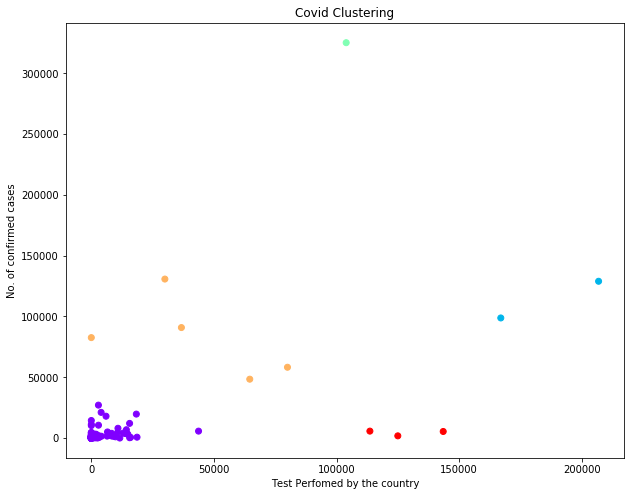

In [19]:

##### Grouping countries into 5 different clusters based on no. of test performed, cases confirmed, deaths and recovered cases and different health indicators showing the health care condition
kmeans_covid = KMeans(n_clusters = 5, init='k-means++', max_iter=300, n_init=10)
y_kmeans = kmeans.fit_predict(data_k)

# Fitting K-Means to the dataset
kmeans = KMeans(n_clusters = 5, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(data_k)


#beginning of  the cluster numbering with 1 instead of 0
y_kmeans1=y_kmeans
y_kmeans1=y_kmeans+1

# New Dataframe called cluster
cluster = pd.DataFrame(y_kmeans1)
# Adding cluster to the Dataset1
data_k['cluster'] = cluster

plt.figure(figsize=(10, 8))
plt.scatter(data_k.iloc[:,0], data_k.iloc[:,1],c=y_kmeans, cmap='rainbow')  # plot points with cluster dependent colors
plt.title('Covid Clustering')
plt.xlabel("Test Perfomed by the country")
plt.ylabel("No. of confirmed cases")
plt.savefig('clustering_result.png')
plt.show()


In [17]:
#Mean of clusters
kmeans_mean_cluster = pd.DataFrame(round(data_k.groupby('cluster').mean(),1))
kmeans_mean_cluster


,total_covid_19_tests,confirmed,deaths,recovered,active,inform_risk,inform_p2p_hazard_and_exposure_dimension,population_density,people_using_at_least_basic_sanitation_services,inform_vulnerability,inform_epidemic_vulnerability,prevalence_of_undernourishment,inform_lack_of_coping_capacity
cluster,,,,,,,,,,,,,
1,1721.9,1399.1,48.2,198.2,1095.9,3.5,4.1,190.5,67.4,3.4,4.7,11.1,4.2
2,186943.0,113860.0,8707.0,25257.5,79895.5,2.3,2.8,221.4,99.0,3.0,5.2,2.4,1.8
3,103945.0,325185.0,9267.0,16820.0,0.0,3.4,2.8,35.8,100.0,2.9,5.7,2.4,2.1
4,42273.6,82172.2,6374.4,30169.8,45628.0,3.2,3.5,137.9,94.2,3.0,5.1,4.1,2.6
5,127378.0,4291.3,30.0,418.7,3842.7,2.7,3.1,49.2,96.4,2.0,4.6,2.5,2.8


In [18]:
data_risk= pd.DataFrame()
data_risk["country"]=data_tmp["country_region"]
data_risk["Risk_Level"]=y_kmeans1
for group in range(1,6):
    countries=data_risk.loc[data_risk['Risk_Level']==group]
    listofcoutries= list(countries['country'])
    print("Group", group, ":", listofcoutries)

Group 1 : ['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan', 'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil', 'Brunei', 'Bulgaria', 'Burkina Faso', 'Burma', 'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada', 'Central African Republic', 'Chad', 'Chile', 'Colombia', 'Congo (Brazzaville)', 'Congo (Kinshasa)', 'Costa Rica', "Cote d'Ivoire", 'Croatia', 'Cuba', 'Cyprus', 'Czechia', 'Denmark', 'Diamond Princess', 'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia', 'Eswatini', 'Ethiopia', 'Fiji', 'Finland', 'Gabon', 'Gambia', 'Georgia', 'Ghana', 'Greece', 'Grenada', 'Guatemala', 'Guinea', 'Guinea-Bissau', 'Guyana', 'Haiti', 'Holy See', 'Honduras', 'Hungary', 'Iceland', 'India', 'Indonesia', 'Iraq', 'Ireland', 'Israel', 'Jamaica',